In [71]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque


In [72]:
print(torch.cuda.is_available())  # 應該為 True
print(torch.version.cuda)         # 應該列出 CUDA 版本
print(torch.backends.cudnn.version())  # cuDNN 版本


True
12.1
90100


In [73]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game


In [ ]:
class SpaceShipEnv():
    def __init__(self):
        pygame.init()
        pygame.font.init()

        # 延後畫面初始化，等 render() 時才設置
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game()

        self.action_space = [0, 1, 2, 3]
        self.observation = self.game.state
        self.prev_score = 0
        self.prev_health = self.game.player.sprite.health
        self.score_milestones = set()

        self.combo = 0
        self.prev_combo = 0
        self.last_hit_frame = 0
        self.no_hit_steps = 0
    
        self.a_second_reward = 0.0
        self.a_second_score = 0
        self.total_dist_penalty = 0.0

        self.last_collision_frame = 0 # 上次碰撞的幀數
        self.low_health_penalty_cooldown = 0  # 冷卻計數器
        self.low_health_penalty_interval = 60  # 每 60 幀才扣一次分

        

    def step(self, action):
        self.game.update(action)

        if self.screen is None:
            self.game.draw()
        else:
            self.game.draw(self.screen)
            self.clock.tick(self.fps)

        # define the state by your game logic
        state = self.game.state

        # reward calculation        
        HIT_COMBO_INTERVAL = 50
        COMBO_RESET_INTERVAL = 120
        NO_HIT_THRESHOLD = 120

        if self.game.is_hit_rock:
            if self.game.frame_count - self.last_hit_frame <= HIT_COMBO_INTERVAL:
                self.combo += 1
            else:
                self.combo = 1
            self.last_hit_frame = self.game.frame_count
            self.no_hit_steps = 0
        else:
            self.no_hit_steps += 1
            if self.game.frame_count - self.last_hit_frame > COMBO_RESET_INTERVAL:
                self.combo = 0


        # --- 石頭懲罰 ---
        player_x, player_y = self.game.player.sprite.rect.centerx, self.game.player.sprite.rect.centery
        min_dist = float('inf')
        close_rock_count = 0
        for rock in self.game.rocks:
            dx, dy = rock.rect.centerx - player_x, rock.rect.centery - player_y
            dist = (dx**2 + dy**2)**0.5
            if dist < min_dist:
                min_dist = dist
            if dist < 50:  # 危險區域判定
                close_rock_count += 1
        # define the reward by your game logic
        # [98 84 40 43 26] 石頭直徑
        # [41.65 36.0 17.0 18.3 10.5] radius = int(self.rect.width * 0.85 / 2)
        # score+=radius*2  health = 100(最大100) damage = radius*1 (扣血)
        # 道具掉落率 5%
        # --- reward 起始 ---
        reward = 0.0
        score = self.game.score
        frame = self.game.frame_count
        hit_inc = score - self.prev_score

        # 分數級別調整
        if score < 200:
            hit_scale, combo_threshold, combo_scale, milestone_scale = 0.35, 5, 0.25, 2.5
        elif score < 1000:
            hit_scale, combo_threshold, combo_scale, milestone_scale = 0.5, 4, 0.3, 4.0
        elif score < 3000:
            hit_scale, combo_threshold, combo_scale, milestone_scale = 0.6, 3, 0.45, 6.0
        else:
            hit_scale, combo_threshold, combo_scale, milestone_scale = 0.65, 3, 0.3, 4.0

        # --- 擊中石頭 reward ---
        if self.game.is_hit_rock:
            early_boost = 1.2 if frame < 1800 else 1.0
            gain = hit_scale * hit_inc * (0.97 ** (frame // 3600)) * early_boost
            reward += gain
            # print("Hit Rock Reward:", hit_inc, "Reward:", reward)

        # --- Combo Bonus ---
        if self.combo >= combo_threshold and self.combo > self.prev_combo:
            bonus = min(combo_scale * np.log(self.combo + 1) * self.combo, 15)
            reward += bonus
            # print("Combo Bonus:", self.combo, "Reward:", reward)

        # --- 道具 ---
        if self.game.is_power_shield:
            reward += 6
            # print("Shield Reward:", reward)
        if self.game.is_power_gun:
            reward += 5
            # print("Power-up Reward:", reward)

        # --- 回血獎勵 ---
        current_health = self.game.player.sprite.health 
        if self.prev_health <= 30 and current_health > 40 and score >= 100:
            reward += 4.0
            # print("Recovered Health Bonus: +4.0")

        # --- 血量懲罰 ---
        current_health = self.game.player.sprite.health

        # 檢查是否從健康掉到低血
        if self.prev_health > 30 and current_health <= 30:
            low_health_penalty = - (1 - current_health / 100) * 5
            reward += low_health_penalty
            # print(f"Low Health Penalty Triggered: {low_health_penalty:.2f}")

        # --- 碰撞懲罰---
        penalty = 0.0
        if self.game.is_collided:
            radius = self.game.is_collided_radius
            penalty = min(0.8 * radius, 20)   # 損傷懲罰上限為 -5
            reward -= penalty
            # print(f"Collision Penalty: -{penalty:.2f}")
            if self.last_collision_frame and frame - self.last_collision_frame <= 30:
                penalty *= 1.5
            self.last_collision_frame = frame
            reward -= penalty

        # --- 距離石頭懲罰 ---
        distance_penalty = 0.0
        # --- 距離石頭過近懲罰（非命中時） ---
        if not self.game.is_hit_rock:
            if 40 < min_dist < 70:
                distance_penalty = - ((70 - min_dist) ** 1.5) * 0.02
                self.total_dist_penalty += distance_penalty
                self.total_dist_penalty = max(self.total_dist_penalty, -6.0)  # 限制懲罰上限
        
        if close_rock_count >= 3:
            danger_penalty = -1.5 - 0.5 * (close_rock_count - 3)
            reward += danger_penalty
            # print(f"Danger Zone Penalty: {danger_penalty:.2f}")


        # --- 里程碑獎勵 ---
        milestone = (score // 500) * 500
        if milestone >= 100 and milestone not in self.score_milestones:
            bonus = max(1, milestone_scale * np.exp(-score / 2000))
            reward += bonus
            self.score_milestones.add(milestone)
            # print("Score Milestone Reached:", milestone, "Reward:", reward)

        # --- Miss 懲罰 ---
        if self.no_hit_steps >= NO_HIT_THRESHOLD and frame % 60 == 0:
            miss_penalty = min(1.5, (self.no_hit_steps - NO_HIT_THRESHOLD) * 0.1)
            reward -= miss_penalty
            # print("Miss Penalty:", miss_penalty, "Reward:", reward)

        # --- 生存獎勵 ---
        if frame % (5 * 60) == 0:
            if score < 300:
                reward += 2.0
            elif score < 1000:
                reward += 3.0
            else:
                reward += 4.0

        
        
        # --- 死亡懲罰 ---
        if not self.game.running:
            survival_seconds = frame / 60
            death_penalty = -200 * np.exp(-survival_seconds / 40)
            reward += death_penalty
            # print(f"({frame / 60}) Reward : {self.a_second_reward:.2f} Score: {self.a_second_score} dist_pently: {self.total_dist_penalty}\n")
            # self.a_second_reward = 0.0
            # self.a_second_score = 0
            self.total_dist_penalty = 0.0
        else:
            # self.a_second_reward += reward
            # self.a_second_score += hit_inc
            if frame % 60 == 0:
                # print(f"({frame / 60}) Reward : {self.a_second_reward:.2f} Score: {self.a_second_score} dist_pently: {self.total_dist_penalty}\n")
                # self.a_second_reward = 0.0
                # self.a_second_score = 0
                self.total_dist_penalty = 0.0

        # --- 非線性壓縮 ---
        reward = np.tanh(reward / 200.0) * 100

        # --- 狀態更新 ---
        self.prev_combo = self.combo
        self.prev_score = score
        self.prev_health = self.game.player.sprite.health
        # ------------------------------------
    
        done = not self.game.running or self.game.score >= 10000

        info = {
            "score": self.game.score,
            "health": self.game.player.sprite.health
        }
        
        return state, reward, done, info

    def reset(self):
        self.game = Game()
        self.prev_score = 0
        return self.game.state

    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

    def close(self):
        pygame.quit()


In [75]:
# Hyperparameters
num_episodes = 4000
batch_size = 256
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.999
memory_capacity = 100000  # 100000
target_update_freq = 2000   # 1000

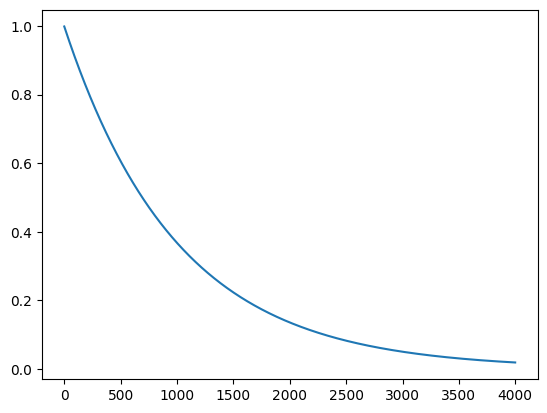

In [76]:
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [78]:
class DDQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x / 255.0)
        return self.fc(x)


In [79]:
# Replay buffer
# 用於儲存代理人經驗（狀態、動作、獎勵等）的緩衝區，支援隨機抽樣以打破時間相關性，有助於穩定訓練。

class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # Use deque with a fixed capacity to automatically discard the oldest experience when full.
        # 使用 deque 並設定最大長度，當容量滿時會自動移除最舊的資料。

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        # Store a single transition (experience) in the buffer.
        # 儲存一筆經驗（狀態轉移）進緩衝區。

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Randomly sample a batch of transitions to break correlation between consecutive samples.
        # 隨機抽取一批經驗，打破樣本間的時間關聯性，提高訓練穩定性。

        # Unpack each element into separate tensors for network input
        # 將 batch 拆解成分別的 tensor 以供神經網路訓練
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert the sampled data into tensors and move them to the specified device (CPU or GPU)
        # 將抽樣資料轉成 tensor 並移至指定設備（CPU/GPU）

        # states = torch.tensor(np.stack(states), dtype=torch.float32, device=device)
        # actions = torch.tensor(actions, dtype=torch.int64, device=device)
        # rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        # next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=device)
        # dones = torch.tensor(dones, dtype=torch.float32, device=device)
        # return states, actions, rewards, next_states, dones
        # 檢查 state shape
        
        # 先在 CPU 上創建 Tensor，然後 pin memory 
        states = torch.stack(states).pin_memory()
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).pin_memory()
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).pin_memory()
        next_states = torch.stack(next_states).pin_memory()
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).pin_memory()
        
        return states, actions, rewards, next_states, dones
    
        # return (
        #     torch.stack(states),
        #     torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1),  # Add dimension for actions
        #     torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1),  # Add dimension for rewards    
        #     torch.stack(next_states),
        #     torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)  # Add dimension for dones
        # )

    def __len__(self):
        return len(self.buffer)
        # Return the current size of the buffer.
        # 回傳緩衝區目前儲存的資料數量。


In [80]:
# Preprocess frames (grayscale and resize to 84x84)
# 預處理影格：轉為灰階並縮放為 84x84

import cv2
def preprocess_state(state, stacked_state=None, is_new=False):
    gray = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    gray = torch.tensor(gray, dtype=torch.uint8).unsqueeze(0)        # (1,84,84)
    if is_new or stacked_state is None:
        stacked_state = gray.repeat(4, 1, 1)                         # (4,84,84)
    else:
        stacked_state = torch.cat((gray, stacked_state[:-1]), dim=0)
    return stacked_state.float().unsqueeze(0), stacked_state         # (1,4,84,84)


def preprocess_frame(frame):
    # frame 是 numpy array (H, W, 3)，先轉為 PIL Image
    # Input is a color image (RGB), convert to PIL format for easier processing.
    # 輸入是彩色圖像（RGB），轉成 PIL Image 以方便處理。
    image = Image.fromarray(frame)

    # 轉灰階
    # Convert the image to grayscale to reduce input complexity.
    # 將影像轉為灰階，降低輸入維度與計算量。
    image = image.convert('L')

    # resize 成 84x84
    # Resize the image to a standard 84x84 shape, as per DQN convention.
    # 依照 DQN 的慣例將影像統一縮放至 84x84。
    image = image.resize((84, 84), Image.Resampling.BILINEAR)  # or NEAREST, or LANCZOS

    # 轉回 numpy 並正規化
    # Convert back to NumPy and normalize pixel values to [0, 1].
    # 轉回 NumPy 格式並將像素值標準化到 [0, 1]。
    frame = np.asarray(image, dtype=np.float32) / 255.0

    return frame


def stack_frames(stacked_frames, state, is_new_episode):
    # 預處理目前影格
    frame = preprocess_frame(state)

    if is_new_episode or stacked_frames is None:
        # If it's a new episode or no previous frames, initialize with 4 identical frames
        # 若是新的一集或是尚未初始化，則用目前影格複製 4 次形成初始堆疊
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        # 否則把新影格加入到堆疊中，自動捨棄最舊的
        stacked_frames.append(frame)

    # Stack the 4 frames along the first dimension: shape becomes (4, 84, 84)
    # 沿著第一維（channel）堆疊成 4 通道輸入：形狀變成 (4, 84, 84)
    stacked_state = np.stack(stacked_frames, axis=0)

    return stacked_state, stacked_frames


In [81]:
# 初始化 Breakout 環境 / Initialize the Breakout environment
import torch.amp

env = SpaceShipEnv()
num_actions = len(env.action_space)
state_dim = 4
# 建立策略網路與目標網路 / Create policy and target networks
policy_net = DDQN(state_dim, num_actions).to(device)
target_net = DDQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # 初始時讓目標網路等於策略網路
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(memory_capacity)
scaler = torch.amp.GradScaler() 

checkpoint_prefix = 'checkpoint_DDQN_V3'

# 載入模型（若有）
if os.path.exists(f'{checkpoint_prefix}.pth'):
    checkpoint = torch.load(f'{checkpoint_prefix}.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode   = checkpoint['episode'] + 1
    frame_idx       = checkpoint['total_steps']
    best_score      = checkpoint['best_score']
    epsilon         = checkpoint['epsilon']
    reward_history  = checkpoint['reward_history']
    score_history   = checkpoint['score_history']
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    frame_idx    = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []


# 訓練迴圈 / Training loop
# 每次可以訓練個100步(根據自己的設備與時間調整)，然後下一次都再接續上次的訓練模型接續往下訓練
# You can train for 100 steps each time (adjust according to your own equipment and time), 
# and then continue training from the last training model next time.
for episode in range(start_episode, 4000): # last time = 3200
    cur_state_b, cur_state = preprocess_state(env.reset(), None, True)  # 回傳 4×84×84
    episode_reward = 0
    # state, stacked_frames = stack_frames(None, state, True)
    done = False

    while not done:
        # env.render()  # 確保畫面被渲染 / Ensure the screen is rendered
        # pygame.event.pump()  # 處理 Pygame 事件 / Process Pygame events
        # ε-greedy 策略：隨機選擇動作或從模型中選擇 / Epsilon-greedy action selection
        # if random.random() < epsilon:
        #     action = random.choice(env.action_space)
        # else:
        #     with torch.no_grad():
        #         state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        #         action = policy_net(state_tensor).argmax(dim=1).item()

        frame_idx += 1
        if random.random() < epsilon:
            action = random.randrange(num_actions)
        else:
            with torch.no_grad():
                q = policy_net(cur_state_b.to(device))
                action = q.argmax(dim=1).item()  # 取得最大 Q 值對應的動作

        # 執行動作 / Perform action
        next_state_raw, reward, done, info = env.step(action)

        next_state_b, next_state = preprocess_state(next_state_raw, cur_state, False)
        # 存入經驗  (去掉 batch 維度)
        memory.push(cur_state.cpu(), action, reward, next_state.cpu(), done)
        cur_state_b, cur_state = next_state_b, next_state
        episode_reward += reward

        # 訓練模型 / Train the model from memory
        if len(memory) >= batch_size:
            for _ in range(1): # 你可以調整這個數字，例如 2 或 4
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                states = states.to(device, non_blocking=True)
                next_states = next_states.to(device, non_blocking=True)
                actions = actions.to(device, non_blocking=True)
                rewards = rewards.to(device, non_blocking=True)
                dones = dones.to(device, non_blocking=True)

                with torch.amp.autocast("cuda"):
                    # DDQN target
                    q_values = policy_net(states).gather(1, actions)
                    # 用 policy_net 選擇 next action
                    next_actions = policy_net(next_states).argmax(1, keepdim=True)
                    # 用 target_net 計算該 action 的 Q 值
                    next_q_values = target_net(next_states).gather(1, next_actions).detach()
                    expected_q = rewards + (gamma * next_q_values * (1 - dones))

                    loss = F.mse_loss(q_values, expected_q)

                optimizer.zero_grad()
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # --- 更新 target_net ---
        if frame_idx % target_update_freq == 0: 
            target_net.load_state_dict(policy_net.state_dict())
        
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # 更新 epsilon 並紀錄統計資料 / Decay epsilon and log results
    
    reward_history.append(episode_reward)
    score_history.append(info['score'])
    
    print(f"Episode {episode + 1:3d}, Reward: {episode_reward:7.2f}, Score: {info['score']:7.2f}, Epsilon: {epsilon:5.3f}")

    # 儲存模型（若比目前最佳分數更好，或每 50 回合）
    if (episode + 1) % 50 == 0 or info['score'] > best_score:
        best_score = max(best_score, info['score'])

        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': frame_idx,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, f'{checkpoint_prefix}.pth')

        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")
    # 儲存模型（每 100 回合）

    

    if (episode + 1) % 100 == 0 :
        best_score = max(best_score, info['score'])
        import os
        checkpoint_dir = checkpoint_prefix
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(
            checkpoint_dir, f'{checkpoint_prefix}_{episode + 1}.pth'
        )
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': frame_idx,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, checkpoint_path)

        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")

env.close()


C:\Users\Wei\AppData\Local\Temp\ipykernel_34476\3161115868.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{checkpoint_prefix}.pth', map_locat

Loaded checkpoint from episode 4, best score: 1144.00, epsilon=0.996
Episode   5, Reward:   38.78, Score:  454.00, Epsilon: 0.995
Episode   6, Reward:  296.57, Score: 1208.00, Epsilon: 0.994
Checkpoint saved at episode 6, best score: 1208.00
Episode   7, Reward:   17.88, Score:  414.00, Epsilon: 0.993
Episode   8, Reward:  -10.40, Score:  338.00, Epsilon: 0.992
Episode   9, Reward:  -43.89, Score:  212.00, Epsilon: 0.991
Episode  10, Reward:  -16.82, Score:  322.00, Epsilon: 0.990
Episode  11, Reward:    8.49, Score:  366.00, Epsilon: 0.989
Episode  12, Reward:   -9.83, Score:  326.00, Epsilon: 0.988
Episode  13, Reward:  -32.68, Score:  236.00, Epsilon: 0.987
Episode  14, Reward:   37.43, Score:  468.00, Epsilon: 0.986
Episode  15, Reward:  -45.25, Score:  234.00, Epsilon: 0.985
Episode  16, Reward:  -28.34, Score:  272.00, Epsilon: 0.984
Episode  17, Reward:    1.77, Score:  364.00, Epsilon: 0.983
Episode  18, Reward:  -44.77, Score:  226.00, Epsilon: 0.982
Episode  19, Reward:   39.

KeyboardInterrupt: 

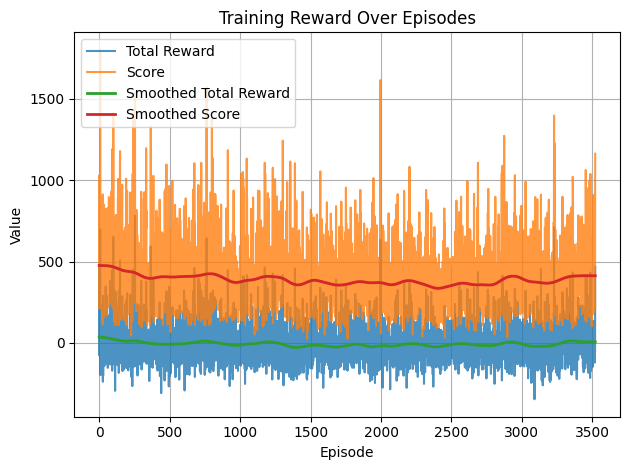

In [12]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
# plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
# plt.savefig("dqn_training_curve.png")